Goal

EASY: ~1.1 MEDIUM: <0.9 MEDIUM-HARD: <0.7 HARD: <0.5
VERY HARD: <0.45

Workflow: 
- Train-val split
- EDA -> find relevant fields 
- Feat engineering train (column transformer goes here too! + eng ourside of pipeline)
- Feat engineering val 
- Model fit
- Model validation
- Regularisation(fit the reg model, play with lambda)
- Model validation

Once happy with validation score: 
- concat Train/Val
- Fit the model total train set
- Feat engineering X_test
- Kaggle submit

### Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Importing packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta

# Import train-test-split
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set_style('whitegrid')

# machine learning stack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# Regularisation
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as ss

### Read the Data

In [2]:
train= pd.read_csv('train.csv')
kaggle_test = pd.read_csv('test.csv')

In [3]:
train = pd.read_csv('train.csv', parse_dates=True)

In [4]:
train.shape

(10886, 12)

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [7]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Define cat and num features 

In [8]:
num_features = ['temp', 'atemp', 'humidity', 'windspeed']
cat_features = ['season', 'holiday', 'workingday', 'weather']
num_feat_counts = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [9]:
features = num_features + cat_features

**Check distribution of targets**

<Axes: xlabel='registered', ylabel='Count'>

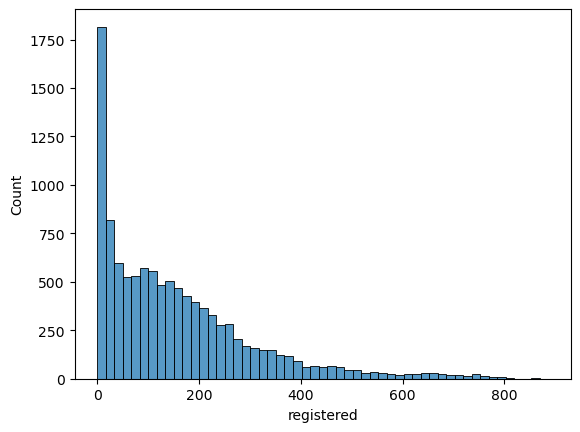

In [10]:
sns.histplot(data = train, x='registered')

<Axes: xlabel='casual', ylabel='Count'>

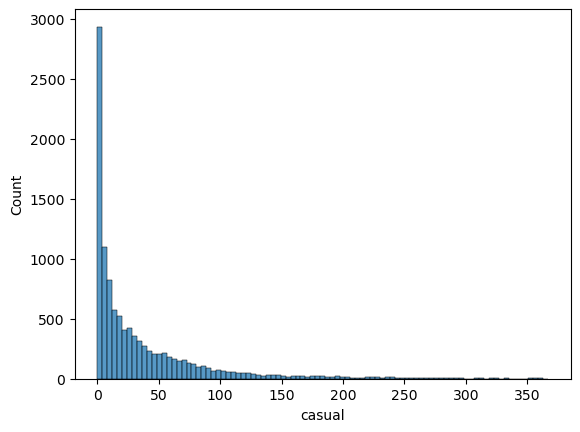

In [11]:
sns.histplot(data = train, x='casual')

Both results show log distribution, use log1p to make results ditribution more symetric
***log1p() method returns log(1+number), computed in a way that is accurate even when the value of number is close to zero.***

***Targets***

In [12]:
y_cas = np.log1p(train['casual'])
y_reg = np.log1p(train['registered'])

<Axes: xlabel='casual', ylabel='Count'>

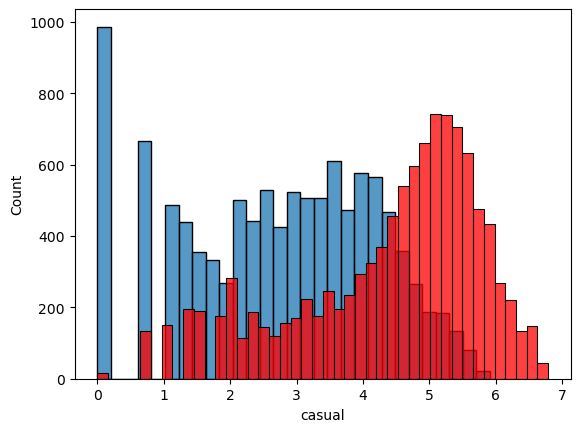

In [13]:
sns.histplot(data = train, x=y_cas)
sns.histplot(data = train, x=y_reg, color = 'red')
#now they represent more symmetric distribution
#in the end will need to untransform with np.expm1

### EDA

**1. Correlations between features**

**Correlation of num features**
High corr -> can remove one of them

<Axes: >

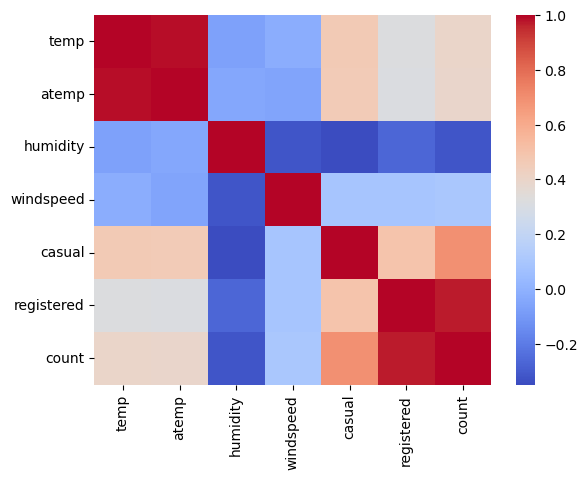

In [14]:
sns.heatmap(data = train[num_feat_counts].corr(),cmap='coolwarm')

Correlation of cat features (Cramers)

In [15]:
#Corrs of categorical features 
#Use provided custom functions dor Cramer's correlation (no method available)
def cramers_corrected_stat(df,cat_col1,cat_col2):
    """
    This function spits out corrected Cramer's correlation statistic
    between two categorical columns of a dataframe 
    """
    crosstab = pd.crosstab(df[cat_col1],df[cat_col2])
    chi_sqr = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r,k = crosstab.shape
    phi_sqr_corr = max(0, chi_sqr/n - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi_sqr_corr / min( (k_corr-1), (r_corr-1)))
    return round(result,3)

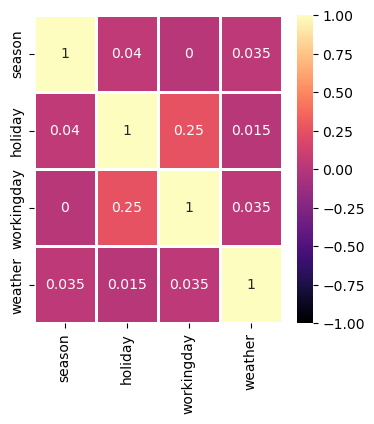

In [16]:
cramer_v_corr = dict(
    zip(
        cat_features,
        [[cramers_corrected_stat(train,f1,f2) for f2 in cat_features] for f1 in cat_features]
    )
)

plt.figure(figsize=(4,4),dpi=100)
sns.heatmap(data=pd.DataFrame(data=cramer_v_corr,index=cat_features),
            cmap='magma',
            linecolor='white',
            linewidth=1,
            annot=True,
            vmin=-1,
            vmax=1
           );

**Correlation of num x cat features**
(chi sq)

In [17]:
#Correlation between numrical and categorical features
#Works with p-values. p_value in all the cases < 0.05 implying likely correlation between categorical and numerical features
def anova_pvalue(df,cat_col,num_col): #probability of no correlation
    """
    This function spits out the anova p-value (probability of no correlation) 
    between a categorical column and a numerical column of a dataframe
    """
    CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
    AnovaResults = ss.f_oneway(*CategoryGroupLists)
    p_value = round(AnovaResults[1],3)
    return p_value

In [18]:
anova_pvalue_dict = dict(
    zip(
        num_feat_counts,
        [[anova_pvalue(train,f1,f2) for f1 in cat_features] for f2 in num_feat_counts]
    )
)

In [19]:
anova_pvalue_dict

{'temp': [0.0, 0.975, 0.002, 0.0],
 'atemp': [0.0, 0.586, 0.01, 0.0],
 'humidity': [0.0, 0.841, 0.256, 0.0],
 'windspeed': [0.0, 0.38, 0.163, 0.0],
 'casual': [0.0, 0.0, 0.0, 0.0],
 'registered': [0.0, 0.029, 0.0, 0.0],
 'count': [0.0, 0.574, 0.226, 0.0]}

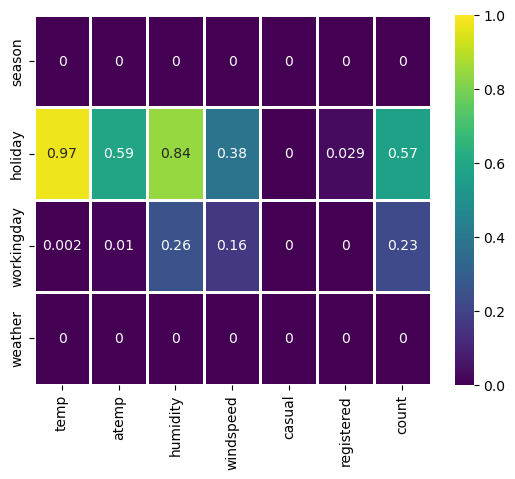

In [20]:
sns.heatmap(data=pd.DataFrame(data=anova_pvalue_dict,index=cat_features),
            cmap='viridis',
            linecolor='white',
            linewidth=1,
            annot=True,
            vmin=0,
            vmax=1
           );

**2. Create time-related features**

In [21]:
#Feature Splitting - add columns to the datataframe with time, date separately
#create new df with datetime columns converted to pandas datetime
train['datetime'] = pd.to_datetime(train['datetime'])

In [22]:
#create new columns with extracted time features using datetime methods
#1 create column date with extracted date 
train['date'] = train['datetime'].dt.date

In [23]:
#3 create column with extract the day name 
train['dayname']= train['datetime'].dt.day_name()

In [24]:
train['month']=train['datetime'].dt.month_name()

In [25]:
train['year']= train['datetime'].dt.year
train['num_month']=train['datetime'].dt.month
train['year_m']= train['year'].astype(str) +"-"+ train["num_month"].astype(str)

In [26]:
train['hour'] = train['datetime'].dt.hour

In [27]:
train.set_index('datetime', inplace=True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,dayname,month,year,num_month,year_m,hour
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,Saturday,January,2011,1,2011-1,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,Saturday,January,2011,1,2011-1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,Saturday,January,2011,1,2011-1,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,Saturday,January,2011,1,2011-1,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,Saturday,January,2011,1,2011-1,4


Counts by day of the week

<Axes: xlabel='dayname'>

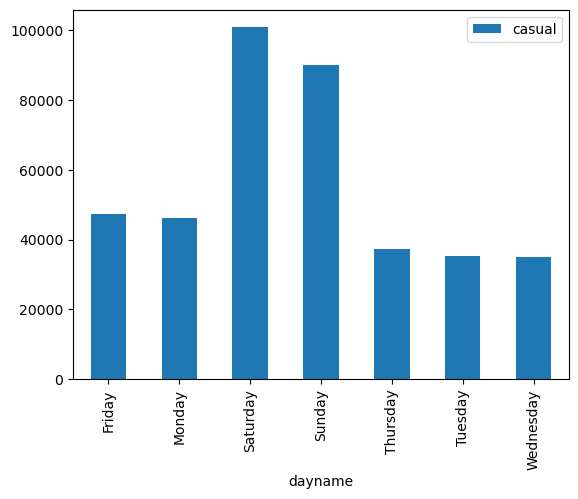

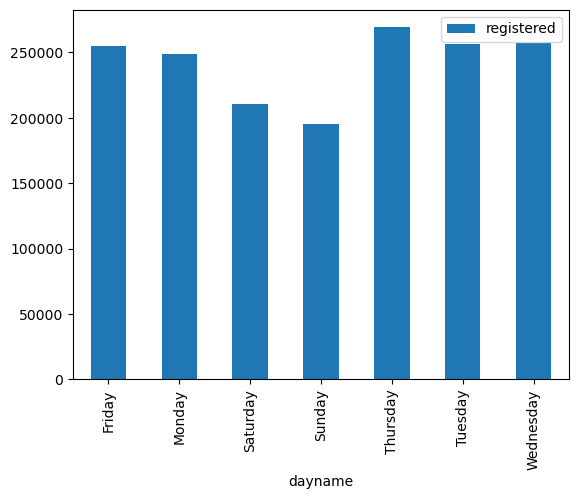

In [28]:
train.groupby('dayname')[['casual']].agg('sum').plot(kind='bar')
train.groupby('dayname')[['registered']].agg('sum').plot(kind ='bar')

Counts by season

<Axes: xlabel='season'>

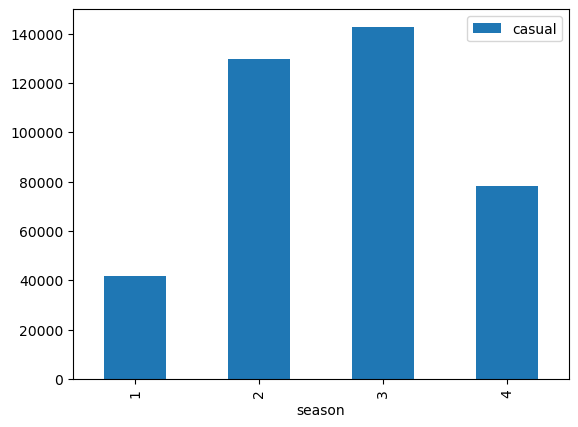

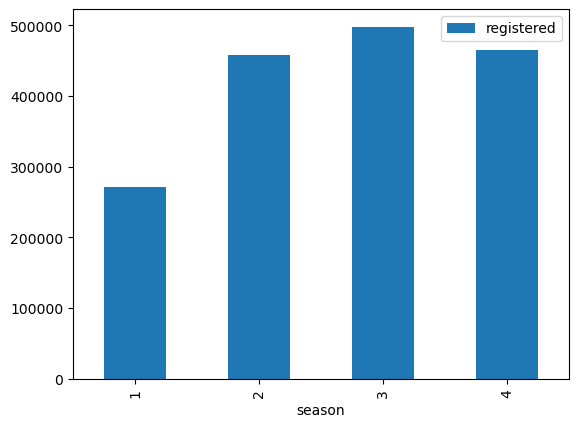

In [29]:
train.groupby('season')[['casual']].agg('sum').plot(kind='bar')
train.groupby('season')[['registered']].agg('sum').plot(kind='bar')

Counts by month (both years)

<Axes: xlabel='year_m'>

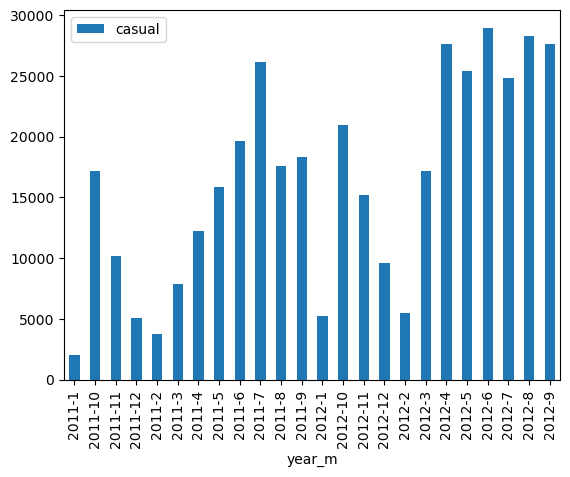

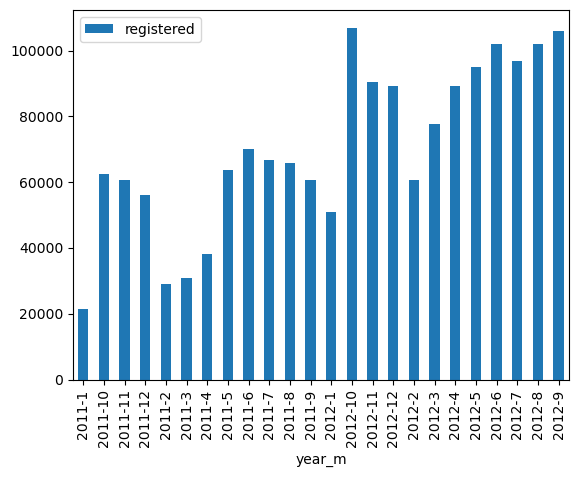

In [30]:
train.groupby('year_m')[['casual']].agg('sum').plot(kind='bar')
train.groupby('year_m')[['registered']].agg('sum').plot(kind='bar')

<Axes: xlabel='hour', ylabel='casual'>

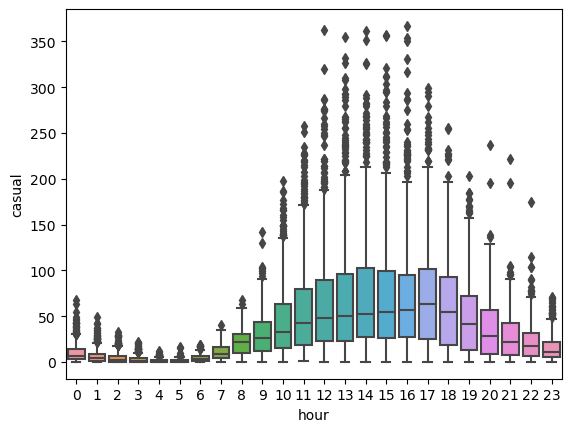

In [31]:
sns.boxplot(x='hour',y='casual', data=train)

<Axes: xlabel='hour', ylabel='registered'>

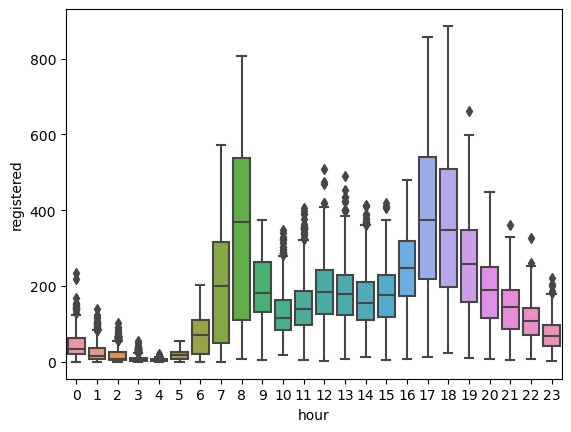

In [32]:
sns.boxplot(x='hour',y='registered', data=train)

Remove outliers

In [33]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

season          2.0000
holiday         0.0000
workingday      1.0000
weather         1.0000
temp           12.3000
atemp          14.3950
humidity       30.0000
windspeed       9.9964
casual         45.0000
registered    186.0000
count         242.0000
year            1.0000
num_month       6.0000
hour           12.0000
dtype: float64


In [34]:

train_without_outliers =train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]
train_without_outliers.dropna(inplace=True)

Fill null windspeed

<Axes: xlabel='windspeed', ylabel='Count'>

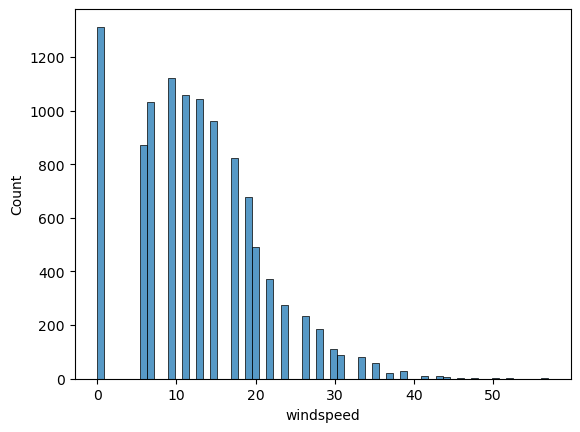

In [35]:
sns.histplot(train['windspeed'])

In [36]:
train_without_outliers['windspeed'] = train_without_outliers['windspeed'].replace(0,np.NaN)
kaggle_test['windspeed'] = kaggle_test['windspeed'].replace(0,np.NaN) 

In [37]:
train_without_outliers['windspeed'].fillna(method='bfill',inplace=True)
train_without_outliers['windspeed'] = train_without_outliers['windspeed'].interpolate()
kaggle_test['windspeed'] = kaggle_test['windspeed'].interpolate()

Final chosen features:

In [38]:
#add missing time columns to test set
kaggle_test['datetime'] = pd.to_datetime(kaggle_test['datetime'])

In [39]:
#create new columns with extracted time features using datetime methods
#1 create column date with extracted date 
kaggle_test['date'] = kaggle_test['datetime'].dt.date

In [40]:
#3 create column with extract the day name 
kaggle_test['dayname']= kaggle_test['datetime'].dt.day_name()

In [41]:
kaggle_test['month']=kaggle_test['datetime'].dt.month_name()

In [42]:
kaggle_test['year']= kaggle_test['datetime'].dt.year
kaggle_test['num_month']=kaggle_test['datetime'].dt.month
kaggle_test['year_m']= kaggle_test['year'].astype(str) +"-"+ kaggle_test['num_month'].astype(str)

In [43]:
kaggle_test['hour'] = kaggle_test['datetime'].dt.hour

In [44]:
#kaggle_test.set_index('datetime', inplace=True)
kaggle_test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,dayname,month,year,num_month,year_m,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011-01-20,Thursday,January,2011,1,2011-1,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,21.002267,2011-01-20,Thursday,January,2011,1,2011-1,1


In [45]:
train_without_outliers.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,dayname,month,year,num_month,year_m,hour
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.0032,3,13,16,2011-01-01,Saturday,January,2011,1,2011-1,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.0032,8,32,40,2011-01-01,Saturday,January,2011,1,2011-1,1


### Final chosen features

In [46]:
#Final chosen features:
cat_features = ['season','holiday','workingday','weather','hour','dayname', 'year_m']
num_features = ['temp','humidity', 'windspeed']
features= cat_features+ num_features

## Building Pipeline

Preprocessing

In [47]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

In [48]:
# one-hot encoding
categorical_transformer = Pipeline(
    steps=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

Grid estimator

In [50]:
estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('rf', RandomForestRegressor()) # random forest regression
    ]
)

Parameter grid

In [51]:
#paramenters within rf -> RandomForestRegressor (see step above)

param_grid = {
    'rf__n_estimators': [100,200,300,500],
    'rf__max_depth': [10,20,50,100,None],
    'rf__min_samples_split': [2, 5, 10]
}

In [52]:
from sklearn.model_selection import GridSearchCV
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=5, 
    n_jobs=4,
    verbose=1
)

In [53]:
X= train_without_outliers[features]
y_cas = np.log1p(train_without_outliers['casual'])
y_reg = np.log1p(train_without_outliers['registered'])

In [108]:
import time

# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X,y_cas)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/e

KeyboardInterrupt: 

In [109]:
round(gscv.best_score_,6)

0.818898

In [110]:
best_model = gscv.best_estimator_

### fit model -> casual

In [111]:
best_model.fit(X,y_cas);

In [112]:
# training score
training_score = best_model.score(X,y_cas)
training_score

0.9581146108067676

Parameter grid -> registered

In [113]:
#find best model for yreg too 
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X,y_reg)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/elizavetabugaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/e

time taken: 1358.08 sec


In [114]:
round(gscv.best_score_,6)

0.819145

In [115]:
best_model_reg = gscv.best_estimator_

## fit model - registered

In [116]:
best_model_reg.fit(X,y_reg);

In [117]:
training_score_r = best_model.score(X,y_reg)
training_score_r

-1.0316056837108714

In [118]:
X_test=kaggle_test[features]

In [120]:
#Predict casual
kaggle_test['casual'] = best_model.predict(X_test) 
y_cas=kaggle_test['casual']
ypred_casual = np.exp(y_cas)-1
kaggle_test['casual'] = ypred_casual
#Predict registered
kaggle_test['registered'] = best_model_reg.predict(X_test)
y_reg=kaggle_test['registered']
ypred_reg = np.exp(y_reg)-1



In [122]:
kaggle_test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,dayname,month,year,num_month,year_m,hour,casual,registered,final_casual,final_registered
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011-01-20,Thursday,January,2011,1,2011-1,0,6.089480,3.959132,5.364100,51.158258
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,21.002267,2011-01-20,Thursday,January,2011,1,2011-1,1,0.484875,1.241277,0.409259,2.413763
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,16.001833,2011-01-20,Thursday,January,2011,1,2011-1,2,1.295262,1.694292,1.202458,4.690013


In [ ]:
kaggle_test.to_csv("kaggle_bike_upload.csv")

Score: 0.46994
